###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2023 Semester 1

## Assignment 1: Music genre classification with naive Bayes


**Student ID(s):**     `1159696`


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

# README

## Environment

The whole program is written using `Python 3.9`.

The following packages are used:

- `scikit-learn version 1.0.2`
- `matplotlib version 3.5.1`
- `pandas version 1.4.1`
- `numpy 1.20.3`

## Run

- Results of the code should easily be seen under each cell .To reproduce or to run the program please run all cells from the top. The cell before Q1 should show a full process from preprocessing and evaluation.
To reproduce results, **please DO NOT change the random seed in Q6**.
- To run the program without modification, please place all datasets in the same folder as the program, and that folder must be in the current folder that this notebook is located.
- To run the program with another dataset, change the file directory in the `preprocess()` function.


## Codes

Please note that Q1 did not use the `evaluate()` function to produce output; rather, it uses a separate function to evaluate model and calculate the metrics that treat “classical” as the true class.

In [19]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt


In [20]:
# This function should prepare the data by reading it from a file and converting it into a useful format for training and testing

def preprocess(csv_file) -> pd.DataFrame:
    """
    Preprocess the data by reading it from a file, dropping unnecessary columns and converting it into a dataframe
    :param csv_file: a csv file containing the data
    :return: a preprocessed dataframe
    """
    data = pd.read_csv(csv_file)
    data = data.drop(columns=['filename']) # drop filename column as it's not correlated with genre

    # fill missing values with average value of the column
    if data.isnull().values.any():
        new_data = pd.DataFrame()
        for label in data['label'].unique():
            new_data = new_data.append(data[data['label'] == label].fillna(data[data['label'] == label].mean()))
        return new_data

    return data

In [21]:
def calculate_prior_probabilities(data: pd.DataFrame) -> dict:
    """
    Calculate prior probabilities for each class
    :param data: a pandas dataframe with labels
    :return: a dictionary containing prior probabilities for each class
    """
    prior_prob = {}
    labels = data['label']
    total_count = len(labels)  # total number of instances
    for label in labels.unique():
        prior_prob[label] = len(labels[labels == label]) / total_count

    return prior_prob

In [22]:
def calculate_mean(data: pd.DataFrame) -> dict:
    """
    Calculate means for each feature for each class
    :param data: a pandas dataframe with labels
    :return: a dictionary containing means for each feature for each class
    """
    means = {}
    for label in data['label'].unique():
        means[label] = data[data['label'] == label].drop(columns='label').mean(numeric_only=True).to_dict()

    return means

In [23]:
def calculate_sd(data: pd.DataFrame) -> dict:
    """
    Calculate standard deviation for each feature
    :param data: a pandas dataframe with labels
    :return: a dictionary containing standard deviation for each feature for each class
    """
    sd = {}
    for label in data['label'].unique():
        sd[label] = data[data['label'] == label].drop(columns='label').std(numeric_only=True).to_dict()

    return sd

In [24]:
# This function should calculat prior probabilities and likelihoods from the training data and using
# them to build a naive Bayes model

def train(data: pd.DataFrame) -> dict:
    """
    Store the model as a dictionary with prior probabilities, means and standard deviations for each class
    :param data: a pandas dataframe with labels
    :return: a dictionary with prior probabilities, means and standard deviations for each class
    """
    model = {}
    prior_prob = calculate_prior_probabilities(data)
    means = calculate_mean(data)
    sd = calculate_sd(data)
    for label in data['label'].unique():
        model[label] = {
            'prior_prob': prior_prob[label],
            'means': means[label],
            'sd': sd[label]
        }

    # print(model)
    return model

In [25]:
def calc_gaussian_prob(x, mean, sd) -> float:
    """
    Calculate the probability of x given the mean and standard deviation
    :param x: a value
    :param mean: mean of the distribution regarding x
    :param sd: standard deviation of the distribution regarding x
    """
    left = 1 / (sd * np.sqrt(2 * np.pi))
    right = np.exp(-((x - mean) ** 2) / (2 * sd ** 2))
    # return epsilon if gaussian probability is 0 to avoid log(0)
    if left * right == 0:
        return np.finfo(float).eps
    return left * right

In [26]:
def calc_posterior_prob(model, instance: dict) -> dict:
    """
    Calculate the posterior probability of each class given for an instance
    :param model: a dictionary containing prior probabilities, means and standard deviations for each class
    :param instance: a dictionary containing a feature and its values
    :return: a dictionary containing posterior probabilities for each class for the instance
    """
    posterior_prob = {}
    for label in model.keys():
        prior_prob = model[label]['prior_prob']
        likelihood = 0
        for feature in instance.keys():
            if feature == 'label':
                continue
            if not instance[feature]:
                continue
            else:
                mean = model[label]['means'][feature]
                sd = model[label]['sd'][feature]
                likelihood += np.log(calc_gaussian_prob(instance[feature], mean, sd))
                posterior_prob[label] = np.log(prior_prob) + likelihood

    return posterior_prob

In [27]:
def find_highest_posterior_prob(posterior_prob: dict) -> str:
    """
    Find the class with the highest posterior probability
    :param posterior_prob: a dictionary containing posterior probabilities for each class for an instance
    :return: the class with the highest posterior probability
    """
    highest_prob = float('-inf')
    highest_label = None
    for label in posterior_prob.keys():
        if posterior_prob[label] > highest_prob:
            highest_prob = posterior_prob[label]
            highest_label = label

    return highest_label

In [28]:
# This function should predict classes for new items in a test dataset

def predict(model, test_data: pd.DataFrame) -> list:
    """
    Predict the class for each instance of a dataset
    :param model: a dictionary containing prior probabilities, means and standard deviations for each class
    :param test_data: a test dataset in pandas dataframe format
    :return: a list of predicted classes
    """
    results = []
    # drop label column if it exists before predicting
    if "label" in test_data.columns.to_list():
        test_data = test_data.drop(columns=['label'])
    # find the class with the highest posterior probability in each instance
    for index, row in test_data.iterrows():
        posterior_prob = calc_posterior_prob(model, row.to_dict())
        results.append(find_highest_posterior_prob(posterior_prob))

    return results

In [29]:
# This function should evaliate the prediction performance by comparing your model’s class outputs to ground
# truth labels

def evaluate(model, y_pred, test_data: pd.DataFrame=None, true_labels=None):
    """
    Evaluate the prediction performance by comparing the predicted classes to ground truth labels and show a report and a confusion matrix
    :param model: a dictionary containing prior probabilities, means and standard deviations for each class
    :param y_pred: predicted classes
    :param test_data: a test dataset in pandas dataframe format
    :param true_labels: true labels of the test dataset
    :return: None
    """
    if true_labels is None:
        true_labels = test_data['label'].to_list()

    print(classification_report(true_labels, y_pred))
    cm = confusion_matrix(true_labels, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.keys())
    disp.plot()

    return

              precision    recall  f1-score   support

   classical       0.95      1.00      0.98        20
         pop       1.00      0.96      0.98        23

    accuracy                           0.98        43
   macro avg       0.98      0.98      0.98        43
weighted avg       0.98      0.98      0.98        43



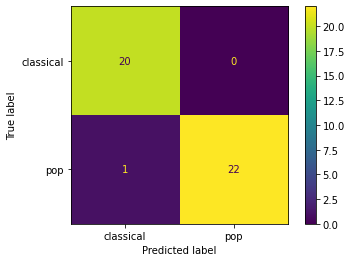

In [30]:
"""
This shows the full process of training and evaluating a model
"""
train_data = preprocess('COMP30027_2023_asst1_data/pop_vs_classical_train.csv')
test_data = preprocess('COMP30027_2023_asst1_data/pop_vs_classical_test.csv')
model = train(train_data)
y_pred = predict(model, test_data)
evaluate(model, y_pred=y_pred, test_data=test_data)

## Task 1. Pop vs. classical music classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

### Q1
Compute and report the accuracy, precision, and recall of your model (treat "classical" as the "positive" class).

In [31]:
def evaluate_pop_classical(model, y_pred, test_data: pd.DataFrame=None, true_labels=None):
    """
    Evaluate the prediction performance by comparing the predicted classes to ground truth labels and show a report and a confusion matrix for pop vs classical with classical as the positive class
    :param model: a dictionary containing prior probabilities, means and standard deviations for each class
    :param y_pred: predicted classes
    :param test_data: a test dataset in pandas dataframe format
    :param true_labels: true labels of the test dataset
    :return: a dictionary containing accuracy, precision, recall, and f1-score
    """
    if true_labels is None:
        true_labels = test_data['label'].to_list()

    # consider classical as the positive class and calculate tp, fp, tn, fn
    tp, fp, tn, fn = 0, 0, 0, 0
    for i in range(len(y_pred)):
        if y_pred[i] == 'classical' and true_labels[i] == 'classical':
            tp += 1
        elif y_pred[i] == 'classical' and true_labels[i] == 'pop':
            fp += 1
        elif y_pred[i] == 'pop' and true_labels[i] == 'pop':
            tn += 1
        elif y_pred[i] == 'pop' and true_labels[i] == 'classical':
            fn += 1

    # calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    # calculate precision
    precision = tp / (tp + fp)
    # calculate recall
    recall = tp / (tp + fn)
    f1 = f1_score(true_labels, y_pred, average='macro')

    # plot confusion matrix
    cm = confusion_matrix(true_labels, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.keys())
    disp.plot()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

{'accuracy': 0.9767441860465116,
 'precision': 0.9523809523809523,
 'recall': 1.0,
 'f1': 0.9766937669376694}

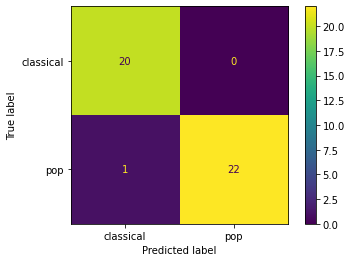

In [32]:
"""
This shows the full process of training and evaluating the model for pop vs classical
"""
train_data = preprocess('COMP30027_2023_asst1_data/pop_vs_classical_train.csv')
test_data = preprocess('COMP30027_2023_asst1_data/pop_vs_classical_test.csv')
model = train(train_data)
y_pred = predict(model, test_data)

evaluate_pop_classical(model, y_pred=y_pred, test_data=test_data)

### Q2
For each of the features X below, plot the probability density functions P(X|Class = pop) and P(X|Class = classical). If you had to classify pop vs. classical music using just one of these three features, which feature would you use and why? Refer to your plots to support your answer.
- spectral centroid mean
- harmony mean
- tempo

In [33]:
def get_domain(data: pd.DataFrame, feature: str, label: str=None) -> tuple:
    """
    Get the domain(x range) of a feature
    :param data: a dataset in pandas dataframe format
    :param feature: a feature name
    :param label: a label name
    :return: a tuple containing the min and max of the feature
    """
    if label is not None:
        data = data[data['label'] == label][feature]
    else:
        data = data[feature]

    return data.min(), data.max()

In [34]:
def plot_prob_density(data: pd.DataFrame, model: {}, feature: str, domain: ()=None, title: str=None, x_label: str=None, y_label: str=None):
    """
    Plot the probability density function of a feature and save the plot to a file
    :param data: a dataset in pandas dataframe format
    :param model: a dictionary containing prior probabilities, means and standard deviations for each class
    :param feature: a feature name
    :param domain: a tuple containing the min and max of the feature
    :param title: title of the plot
    :param x_label: name of the x-axis
    :param y_label: name of the y-axis
    :return: None
    """
    for label in data['label'].unique():
        label_mean = model[label]['means'][feature]
        label_sd = model[label]['sd'][feature]
        data_mean = data[feature].mean()
        data_sd = data[feature].std()
        if domain is None:
            x = np.linspace(data_mean-4*data_sd, data_mean+4*data_sd, 50, endpoint=True)
        else:
            x = np.linspace(domain[0], domain[1], 50)
        y = []
        for val in x:
            y.append(calc_gaussian_prob(val, label_mean, label_sd))
        plt.plot(x, y)
    plt.legend(data['label'].unique())
    if title is not None:
        plt.title(title)
    if x_label is not None:
        plt.xlabel(x_label)
    if y_label is not None:
        plt.ylabel(y_label)

    plt.savefig(f'{title}.png')
    plt.show()

In [35]:
# train the model
pop_classical_data = preprocess('COMP30027_2023_asst1_data/pop_vs_classical_train.csv')
model = train(pop_classical_data)

Plot the probability density function for each feature:

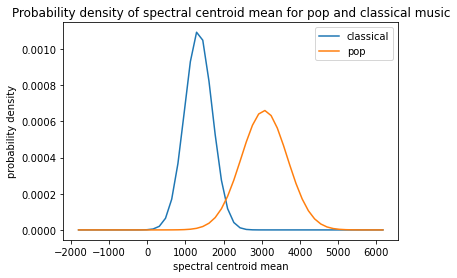

In [36]:
plot_prob_density(pop_classical_data, model, 'spectral_centroid_mean', x_label='spectral centroid mean', y_label='probability density', title='Probability density of spectral centroid mean for pop and classical music')

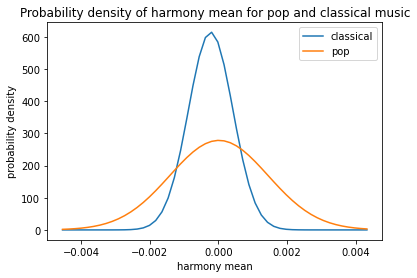

In [37]:
plot_prob_density(pop_classical_data, model, 'harmony_mean', x_label='harmony mean', y_label='probability density', title='Probability density of harmony mean for pop and classical music')

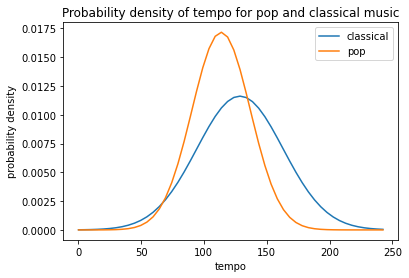

In [38]:
plot_prob_density(pop_classical_data, model, 'tempo', x_label='tempo', y_label='probability density', title='Probability density of tempo for pop and classical music')

## Task 2. 10-way music genre classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

### Q3
Compare the performance of the full model to a 0R baseline and a one-attribute baseline. The one-attribute baseline should be the best possible naive Bayes model which uses only a prior and a single attribute. In your write-up, explain how you implemented the 0R and one-attribute baselines.

### Q4
Train and test your model with a range of training set sizes by setting up your own train/test splits. With each split, use cross-fold validation so you can report the performance on the entire dataset (1000 items). You may use built-in functions to set up cross-validation splits. In your write-up, evaluate how model performance changes with training set size.

### Q5
Implement a kernel density estimate (KDE) naive Bayes model and compare its performance to your Gaussian naive Bayes model. You may use built-in functions and automatic ("rule of thumb") bandwidth selectors to compute the KDE probabilities, but you should implement the naive Bayes logic yourself. You should give the parameters of the KDE implementation (namely, what bandwidth(s) you used and how they were chosen) in your write-up.

### Q6
Modify your naive Bayes model to handle missing attributes in the test data. Recall from lecture that you can handle missing attributes at test by skipping the missing attributes and computing the posterior probability from the non-missing attributes. Randomly delete some attributes from the provided test set to test how robust your model is to missing data. In your write-up, evaluate how your model's performance changes as the amount of missing data increases.

In [39]:
def plot_bar_chart(plot_data: {}, title: str=None, x_label: str=None, y_label: str=None, ylim: ()=None):
    """
    Plot a bar chart and save the plot to a file
    :param plot_data: data needs to be plotted in a dictionary format
    :param title: title of the plot
    :param x_label: name of the x-axis
    :param y_label: name of the y-axis
    :param ylim: a tuple containing the min and max of the y-axis
    :return: None
    """
    # separate the keys and values of the dictionary into data for x and y axis
    x = [str(i) for i in plot_data.keys()]  # convert the keys to string
    y = list(plot_data.values())

    if title is not None:
        plt.title(title)
    if x_label is not None:
        plt.xlabel(x_label)
    if y_label is not None:
        plt.ylabel(y_label)
    if ylim is not None:
        plt.ylim(ylim)
    plt.grid()
    plt.bar(x, y)

    plt.savefig(f'{title}.png')
    plt.show()

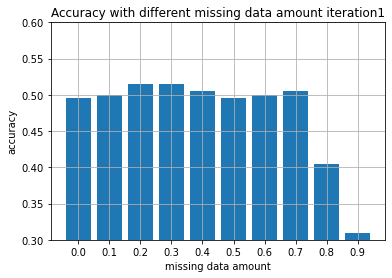

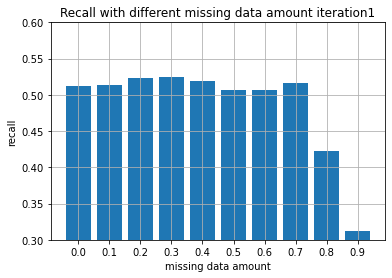

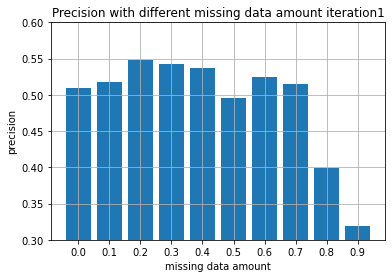

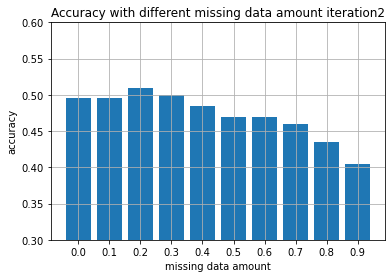

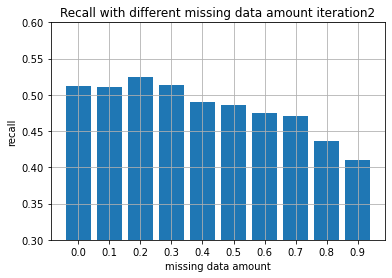

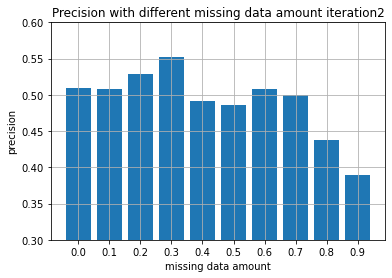

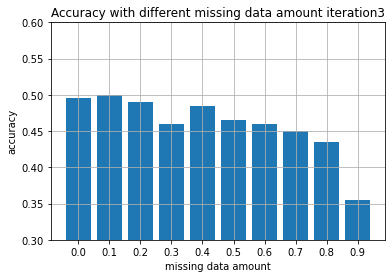

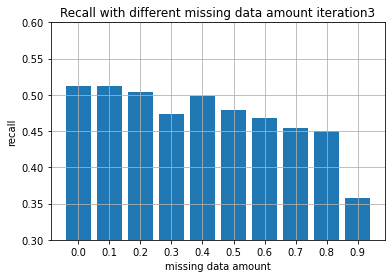

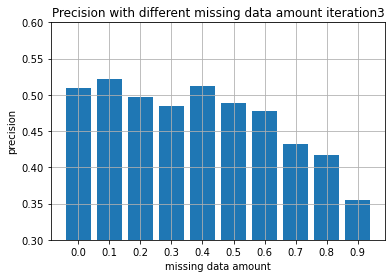

defaultdict(<class 'int'>, {0.0: 0.49499999999999994, 0.1: 0.49833333333333335, 0.2: 0.505, 0.3: 0.4916666666666667, 0.4: 0.4916666666666667, 0.5: 0.4766666666666666, 0.6: 0.4766666666666666, 0.7: 0.4716666666666667, 0.8: 0.42500000000000004, 0.9: 0.3566666666666667})
defaultdict(<class 'int'>, {0.0: 0.5119, 0.1: 0.5125666666666667, 0.2: 0.5172333333333333, 0.3: 0.5041, 0.4: 0.5027666666666667, 0.5: 0.49076666666666674, 0.6: 0.48336666666666667, 0.7: 0.4804, 0.8: 0.43649999999999994, 0.9: 0.36003333333333326})
defaultdict(<class 'int'>, {0.0: 0.5101, 0.1: 0.5160666666666667, 0.2: 0.5249666666666667, 0.3: 0.5263333333333333, 0.4: 0.5139666666666666, 0.5: 0.4900666666666667, 0.6: 0.5036666666666666, 0.7: 0.48266666666666663, 0.8: 0.41769999999999996, 0.9: 0.3542666666666667})


In [40]:
import random
from collections import defaultdict

# train the model using the gztan dataset
train_data = preprocess('COMP30027_2023_asst1_data/gztan_train.csv')
model = train(train_data)

# process the test dataset
test_data = preprocess('COMP30027_2023_asst1_data/gztan_test.csv')
y_ture = test_data['label'].to_list()
test_data = test_data.drop(columns=['label'])

amount = np.arange(0, 1, 0.1) #  emulate missing data from 0% to 90%
feature_amount = len(test_data.columns)

avg_accuracy, avg_recall, avg_precision = defaultdict(int), defaultdict(int), defaultdict(int)

# simulate with 3 iterations with different random seeds to give a more comprehensive result
for k in range(3):
    rand = random.Random(k)
    accuracy, recall, precision = {}, {}, {}

    # simulate missing data with different percentage
    for i in amount:
        temp = test_data.copy()
        for index, row in test_data.iterrows():
            deleted = 0
            for feature in row.keys():
                if feature == 'label': # skip the label column
                    continue
                if rand.random() < i and (deleted < feature_amount - 1):  # avoid deleting all features
                    temp.at[index, feature] = False  # use false to denote missing data
                    deleted += 1

        y_pred = predict(model, temp)

        # calculate performance metrics
        accu = round(accuracy_score(y_ture, y_pred), 4)
        rec = round(recall_score(y_ture, y_pred, average='macro'), 4)
        pre = round(precision_score(y_ture, y_pred, average='macro'), 4)

        # store the performance metrics
        accuracy[round(i, 1)] = accu
        recall[round(i, 1)] = rec
        precision[round(i, 1)] = pre

        avg_accuracy[round(i, 1)] += accu
        avg_recall[round(i, 1)] += rec
        avg_precision[round(i, 1)] += pre

    # plot the performance metrics during each iteration
    plot_bar_chart(accuracy, title=f'Accuracy with different missing data amount iteration{k+1}', x_label='missing data amount', y_label='accuracy', ylim=(0.3, 0.6))
    plot_bar_chart(recall, title=f'Recall with different missing data amount iteration{k+1}', x_label='missing data amount', y_label='recall', ylim=(0.3, 0.6))
    plot_bar_chart(precision, title=f'Precision with different missing data amount iteration{k+1}', x_label='missing data amount', y_label='precision', ylim=(0.3, 0.6))

# calculate the average of performance metrics
for i in amount:
    avg_accuracy[round(i, 1)] /= 3
    avg_recall[round(i, 1)] /= 3
    avg_precision[round(i, 1)] /= 3

print(avg_accuracy)
print(avg_recall)
print(avg_precision)

Plot the average performance metrics

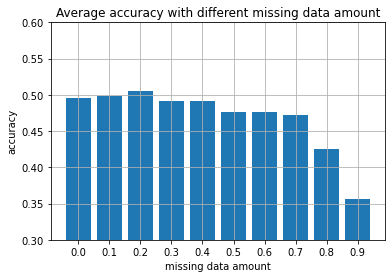

In [41]:
plot_bar_chart(avg_accuracy, title='Average accuracy with different missing data amount', x_label='missing data amount', y_label='accuracy', ylim=(0.3, 0.6))

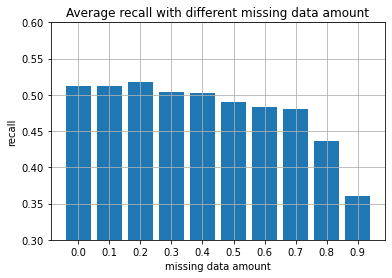

In [42]:
plot_bar_chart(avg_recall, title='Average recall with different missing data amount', x_label='missing data amount', y_label='recall', ylim=(0.3, 0.6))

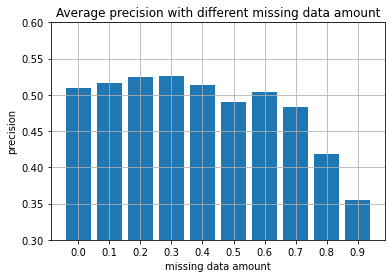

In [43]:
plot_bar_chart(avg_precision, title='Average precision with different missing data amount', x_label='missing data amount', y_label='precision', ylim=(0.3, 0.6))